# 09 - Non Compliance and LATE

## Tremper nos orteils dans un monde hétérogène

Auparavant, nous avons vu les variables instrumentales (IV) sous un angle plus traditionnel. Les IV étaient considérées comme une sorte d'expérience naturelle que nous pouvions exploiter. En revanche, la pratique moderne des IV s'inspire beaucoup des sciences médicales. Elle divise le monde en quatre types de sujets, selon leur réaction à la variable instrumentale.

1. Les Compliers (les observants)
2. Les Never Takers (les refusants systématiques)
3. Les Always Takers (les preneurs systématiques)
4. Les Defiers (les défiants)

Cette nomenclature provient des sciences pharmaceutiques. Imaginez que vous menez une expérience pour tester l'effet d'un nouveau médicament sur une maladie. Chaque sujet se voit attribuer un traitement : un médicament ou un placebo. Les observants sont les sujets qui suivent ce qui leur est assigné. S'ils obtiennent le placebo, ils le prennent ; s'ils obtiennent le médicament, ils le prennent également. Les refusants systématiques sont ceux qui refusent de prendre leur médicament. Même s'ils reçoivent le nouveau médicament, ils ne le prendront pas. D'un autre côté, les preneurs systématiques sont ceux qui peuvent obtenir le nouveau médicament même s'ils reçoivent le placebo. Enfin, les défiants sont ceux qui prennent le traitement s'ils sont assignés au contrôle et prennent le contrôle s'ils sont assignés au traitement. Vous pouvez les considérer comme ces enfants agaçants qui font le contraire de ce qu'on leur dit. En pratique, ils ne sont pas si courants (les défiants, pas les enfants), donc nous les ignorons souvent.

![img](./data/img/late/defiers.png)

La méthode moderne des IV traite l'instrument comme un quasi-design expérimental où la conformité n'est pas parfaite. Ce faisant, elle distingue les effets causaux valides en interne des effets causaux valides en externe. Pour rappel, un effet valide en interne est celui que nous sommes capables d'identifier. Il est valide dans ce contexte particulier, avec ces données particulières. Dans les IV, ce serait l'effet du traitement sur ceux où l'instrument modifie le traitement. La validité externe, en revanche, se préoccupe du pouvoir prédictif de cet effet causal. Elle se demande si nous pourrions généraliser l'effet que nous avons trouvé dans cet échantillon à d'autres populations. Par exemple, supposons que vous ayez mené un essai randomisé contrôlé dans votre université pour déterminer si les gens sont généreux ou non lorsqu'ils reçoivent une incitation à faire un don. L'expérience est bien conçue, mais vous n'invitez que des étudiants en économie à participer. Vous découvrez alors que tous sont des égoïstes. C'est une conclusion valide en interne. Elle est valable pour ces points de données. Mais pouvez-vous, à partir de cette expérience, en déduire que l'humanité est égoïste ? Ce n'est guère le cas. Nous nous demanderions donc si votre expérience a une validité externe pour généraliser ses résultats. Bref, revenons aux IV.

Pour rendre cela plus concret, considérons un cas où vous souhaitez augmenter l'engagement des utilisateurs mesuré par les achats in-app. Une façon de le faire est de demander à votre département marketing de proposer une notification push que vous pouvez utiliser pour engager vos utilisateurs. Ils proposent un design brillant et des interactions utilisateur très sophistiquées. Avec cette notification, vous passez à la conception d'un essai randomisé. Vous sélectionnez 10 000 clients au hasard et, pour chacun d'eux, vous attribuez la notification avec une probabilité de 50 %. Cependant, lorsque vous exécutez le test, vous constatez que certains clients qui étaient censés recevoir la notification ne la reçoivent pas. Lorsque vous parlez aux ingénieurs, ils disent que c'est probablement parce qu'ils ont un téléphone plus ancien qui ne prend pas en charge le type de notification push conçu par l'équipe marketing.

Au début, vous pourriez penser que ce n'est pas un gros problème. Au lieu d'utiliser le traitement assigné comme variable de traitement, vous pouvez simplement utiliser le traitement reçu, n'est-ce pas ? Il s'avère que ce n'est pas si simple. Si vous tracez le graphe causal de toute cette situation, cela ressemblerait à quelque chose comme ceci :

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")

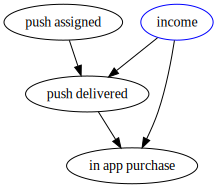

In [2]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

En haut du graphe causal, vous avez l'assignation de la notification push. Ceci est aléatoire par conception, donc rien ne le cause. Ensuite, vous avez un nœud pour savoir si le push a été livré. Tout le monde n'a pas reçu le push assigné, donc vous avez une non-conformité ici. Plus précisément, vous avez des never takers : ceux qui ne reçoivent pas le traitement même s'ils y sont assignés. Vous avez également des raisons de soupçonner que cette non-conformité n'est pas simplement due au hasard. Étant donné que les personnes avec des téléphones plus anciens sont celles qui ne reçoivent pas le push, vous pouvez argumenter que le revenu cause également la livraison du push. Plus une personne est riche, plus elle est susceptible d'avoir un téléphone plus récent, ce qui augmente la probabilité qu'elle reçoive le push. Enfin, vous avez la variable de résultat, les achats in-app. Gardez à l'esprit que nous ne connaissons pas le revenu, nous ne pouvons donc pas le contrôler. Dans ce contexte, examinons ce qui se passerait si nous utilisions simplement le push assigné comme variable de traitement et si, à la place, nous utilisions le push délivré comme traitement.

Dans le premier cas, nous estimerions l'effet causal par la différence de moyennes suivante :

$$
ATE = E[Y | pushAssigned=1] - E[Y | pushAssigned=0]
$$

Comme nous le savons bien maintenant, cela n'est une estimation sans biais de $E[Y_1] - E[Y_0]$ que si le biais $E[Y_0|pushAssigned=0] - E[Y_0|pushAssigned=1]$ est nul. Puisque `pushAssigned` est aléatoire, nous savons que le biais est nul. Est-ce que cela règle le problème ? Pas tout à fait. En fait, en procédant ainsi, nous répondons à une question différente de celle que nous avions l'intention de poser. Nous trouverions l'effet causal de l'assignation du traitement, et non du traitement lui-même. Mais sont-ils différents ou pouvons-nous extrapoler l'effet causal de l'assignation du traitement à l'ATE ? En d'autres termes, l'effet causal de l'assignation du traitement est-il une estimation sans biais de l'ATE ?

Il s'avère que non. En raison de la non-conformité, le résultat de ceux assignés au traitement sera poussé dans la direction du résultat de ceux assignés au contrôle. La non-conformité inverse le traitement de manière non intentionnelle, rendant le traitement et le contrôle plus similaires dans le résultat. Ne confondez pas cela avec la similarité sur les variables. Nous voulons que le groupe traité et le groupe de contrôle soient similaires sur les variables. Cela les rendra comparables. Ce que nous ne voulons pas, c'est qu'ils soient similaires dans le résultat s'il y a effectivement un effet de traitement.

Pour voir cela, supposons d'abord que nous ayons des always takers. Certains d'entre eux seront assignés au groupe de contrôle par hasard. Mais ceux qui le sont prendront le traitement de toute façon. Cela en fait essentiellement un groupe traité qui est mélangé avec le contrôle. En raison de ce mélange, l'effet causal sera plus difficile à trouver lorsque nous avons une non-conformité.

![img](./data/img/late/always_takers.png)

Par le même raisonnement, les never takers feront que ceux assignés au traitement ressembleront un peu aux non-traités, car ils ne prennent pas le traitement même s'ils y sont assignés. En ce sens, **l'effet causal de l'assignation du traitement est biaisé vers zéro** parce que la non-conformité réduit l'impact détectable. Une autre façon de voir cela est d'imaginer un cas extrême. Disons que la non-conformité est très élevée. L'assignation du traitement ne dit rien sur le traitement reçu. Le traitement reçu est purement aléatoire dans ce cas. En termes de IV, cela signifierait que nous avons une première étape très faible. En utilisant `Z` pour désigner l'assignation du traitement, nous aurions que

$$
E[Y|Z=1] - E[Y|Z=0] = 0
$$

Il n'y aurait plus de lien causal entre l'assignation du traitement et le résultat. Z ne serait qu'une variable aléatoire sans signification.

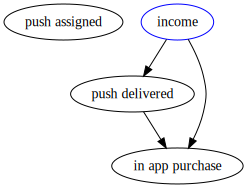

In [3]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

OK, donc nous avons exclu l'utilisation de l'effet causal de l'assignation comme moyen d'estimer l'effet causal du traitement. Alors, qu'en est-il de simplement utiliser le traitement reçu ?

$$
\mathrm{ATE} = E[Y | \mathrm{push}=1] - E[Y | \mathrm{push}=0]
$$

Encore une fois, nous devons réfléchir si cela est biaisé ou non, ou si $E[Y_0|\mathrm{push}=0] = E[Y_0|\mathrm{push}=1]$. En regardant simplement le graphe causal ci-dessus, nous savons que ce n'est pas le cas. Nous avons ce facteur de confusion non mesuré, le revenu, qui rôde et il est certain de perturber les choses. Comme nous l'avons dit plus tôt, nous savons que l'échec de la livraison du push, dans notre cas, est causé par les clients ayant des téléphones plus anciens. Ce qui signifie que nous avons probablement $E[Y_0|\mathrm{push}=0] < E[Y_0|\mathrm{push}=1]$. Nous pensons que c'est le cas parce que les clients avec moins d'argent ont à la fois des téléphones plus anciens, ce qui conduira à $\mathrm{push}=0$, et également un potentiel d'achat in-app $Y_0$ plus faible.

C'est décevant ! Nous ne pouvons pas utiliser le traitement assigné ni le traitement reçu pour estimer notre ATE. Mais heureusement, nous savons ce que nous pouvons utiliser : les variables instrumentales. Ici, le traitement assigné est le parfait instrument pour le traitement. Il est aussi bon que le hasard et il ne cause l'achat in-app que par le biais du traitement.

## Effet de Traitement Moyen Local : LATE

L'effet de traitement moyen local explicite la population pour laquelle nous pouvons estimer l'effet causal. C'est aussi une autre façon de voir les IV, qui donne d'autres intuitions intéressantes. Dans les IV modernes, nous voyons l'instrument comme le début d'une chaîne causale : Z cause T qui cause Y. Dans ce contexte, la restriction d'exclusion signifie que Z ne cause pas Y, sauf par son effet sur T. La première étape est maintenant vue comme l'effet causal de Z sur T. Nous réécrivons également les résultats potentiels avec une notation à double indice, où le premier indice désigne le contrefactuel pour l'instrument et le deuxième indice, pour le traitement

$$
\text{Potential Outcome}=\begin{cases}
Y_i(1, 1) \ \text{si } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{si } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{si } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{si } T_i=0, \ Z_i=0\\
\end{cases}
$$

En un sens, le traitement devient le résultat, du moins dans la première étape. Cela signifie que nous pouvons aussi l'écrire avec la notation des résultats potentiels :

$$
\text{Potential Treatment}=\begin{cases}
T_0 \ \text{si } Z_i=0 \\
T_1 \ \text{si } Z_i=1
\end{cases}
$$

![img](./data/img/late/double_index.png)

Les hypothèses des variables instrumentales peuvent maintenant être réécrites comme suit :

1. $T_{0i}, T_{1i} \perp Z_i $ et $Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i $. Ceci est l'hypothèse d'indépendance. Cela signifie que l'instrument est aussi bon que l'assignation aléatoire. En d'autres termes, Z, l'instrument, n'est pas corrélé avec les traitements potentiels, ce qui revient à dire que les personnes dans différents groupes d'instrument sont comparables.

2. $Y_i(1, 0)=Y_i(1, 1)=Y_{i1}$ et $Y_i(0, 0)=Y_i(0, 1)=Y_{i0}$. Ceci est la restriction d'exclusion. Cela signifie que si je regarde le résultat potentiel pour les traités, il est le même pour les deux groupes d'instrument. En d'autres termes, l'instrument n'affecte pas le résultat potentiel, ce qui revient à dire que l'instrument n'affecte le résultat que par le traitement.

3. $E[T_{1i}-T_{0i}] \neq 0$. Ceci est l'existence d'une première étape. Cela signifie que le résultat potentiel de la première étape, c'est-à-dire le traitement potentiel, n'est PAS le même. Une autre façon de dire cela est que l'instrument affecte le traitement.

4. $T_{i1} > T_{i0}$. Ceci est l'hypothèse de monotonie. Cela signifie que si tout le monde avait l'instrument activé, le niveau de traitement serait plus élevé que si tout le monde avait l'instrument désactivé.

Maintenant, revoyons l'estimateur de Wald pour obtenir une intuition supplémentaire sur les IV :

$$
ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$$

Prenons la première partie, $E[Y|Z=1]$. En utilisant la restriction d'exclusion, nous pouvons réécrire Y en termes de résultat potentiel comme ceci :

$$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]
$$

En utilisant l'indépendance, nous pouvons retirer la condition sur Z.

$$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]
$$

Avec un argument similaire, nous obtenons que

$$
E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]
$$

Nous pouvons maintenant réécrire le numérateur de l'estimateur de Wald comme ceci :

$$
E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]
$$

En utilisant la monotonie, nous savons que $T_{i1}-T_{i0}$ est 0 ou 1, donc

$$
E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})
$$

En utilisant un argument similaire pour traiter le dénominateur, nous obtenons que

$$
E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})
$$

Tout cela nous permet de voir l'estimateur de Wald comme ceci :

$$
ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}>T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]
$$

C'est-à-dire que l'ATE estimé par les IV est l'ATE sur la sous-population où $T_{i1}>T_{i0}$. Et si vous pensez à la conformité, de quelle population s'agit-il ? Il s'agit de la population où ceux qui ont l'instrument activé ont un niveau de traitement plus élevé que s'ils avaient l'instrument désactivé. En d'autres termes, il s'agit de la population des observants. Pour rappel :

1. Les observants signifie que $T_{i1}>T_{i0}$
2. Les refusants systématiques $T_{i1}=T_{i0}=0$
3. Les preneurs systématiques $T_{i1}=T_{i0}=1$

La conclusion de cela est que les IV ne disent rien sur l'effet sur les refusants systématiques, les preneurs systématiques ou les défiants, car le traitement ne change pas pour eux ! **Les IV trouvent uniquement l'effet du traitement pour les observants**.

## Effet sur l'Engagement

Voyons comment tout cela se joue dans l'étude de cas où nous essayons d'estimer l'effet d'un push sur les achats in-app. Le graphe causal est celui que nous avons décrit ci-dessus, donc je ne le répéterai pas ici. Les données que nous avons portent à la fois sur le push assigné, l'instrument randomisé, et le push délivré, la variable de traitement.

In [9]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


D’accord, essayons les moindres carrés ordinaires (OLS) pour voir ce que cela nous donnerait.

In [10]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


D’accord, maintenant que nous avons vu que les OLS indiquent que l’effet du traitement est de 27,60 BRL, nous devons considérer que cette estimation est probablement biaisée. Nous savons que les téléphones plus anciens ont des problèmes pour recevoir le push, ce qui signifie que les clients plus riches, avec des téléphones plus récents, sont les compliers. Puisque ceux qui reçoivent le traitement ont également plus d’argent, nous pensons que ce biais est positif et que l’impact réel du push est inférieur. En d’autres termes, nous avons probablement $E[Y_0|T=0] < E[Y_0|T=1]$.

Passons maintenant à l’estimation de cet effet avec les variables instrumentales. Tout d’abord, exécutons la première étape.

In [11]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0000,7.408e-11,0.0000,1.0000,-1.452e-10,1.452e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


D’accord, il semble que nous ayons une première étape solide. Ceux qui sont assignés à recevoir le push le reçoivent 71,8 % du temps. Cela signifie que nous avons environ 28 % de “never takers”. Nous avons également de bonnes raisons de croire qu’il n’y a pas de “always takers”, puisque le paramètre d’interception est estimé à zéro. Cela signifie que personne ne reçoit le push s’il ne lui est pas assigné. Étant donné le design de notre expérience, cela est attendu.

Passons maintenant à l’exécution de la forme réduite :

In [7]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


La forme réduite montre que l’effet causal de l’assignation du traitement est de 2,36. Cela signifie qu’assigner quelqu’un pour recevoir le push augmente les achats in-app de 2,36 BRL.

Si nous divisons la forme réduite par la première étape, nous mettons à l’échelle l’effet de l’instrument par les unités du traitement, nous obtenons $2.3636/0.7176=3.29$. En exécutant les 2SLS, nous obtenons ces mêmes estimations, avec en bonus des erreurs standards correctes.

In [8]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


Cela montre que le résultat avec les 2SLS est bien inférieur à celui que nous avons obtenu avec les OLS : 3,29 contre 27,60. Cela a du sens, car l’effet causal estimé avec les OLS est biaisé positivement. Nous devons également nous rappeler du LATE. 3,29 est l’effet causal moyen sur les compliers. Malheureusement, nous ne pouvons rien dire sur les never takers. Cela signifie que nous estimons l’effet sur le segment plus riche de la population qui possède des téléphones plus récents.

## Idées Clés

Ici, nous avons examiné une vision plus moderne des Variables Instrumentales (IV). Nous avons vu comment les IV peuvent être considérées comme une chaîne causale où l’instrument cause le traitement qui cause le résultat. Dans cette perspective, nous avons examiné la conformité pour comprendre l’ATE dans l’estimation des IV et nous avons constaté qu’il s’agissait du LATE sur les compliers.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).